# load model and dependencies

In [1]:
!pip install transformers
!pip install torch transformers

from transformers import BartTokenizer, BartForConditionalGeneration

model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

model.config.output_scores = True
import numpy as np
import torch
from torch.nn.functional import softmax
import random
import csv
from scipy import stats

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')
!pip install rouge-score
from rouge_score import rouge_scorer

import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=fa29cc2419a830fd30660aca730620523c942b1f0e36c8c54f621441683bbdea
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# greedy search
model.config.num_beams = 1

In [5]:
model.config.length_penalty = 1.0

In [6]:
model.config.early_stopping = False

In [ ]:
original_text = text
input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)
generated_ids = model.generate(input_ids, max_new_tokens=3, min_length=3, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
print("Generated Summary:", generated_summary)

Generated Summary: D


# Separate functions for differnt parts of the task

## greedy sequential sampling

In [ ]:
# Generating text sequentially(by choosign max probability)
original_text = text
partial_summary = generated_summary
partial_summary_ids = generated_ids.sequences[0][:-1]

for i in range(7):
  gen_num = 4+i
  input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
  input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

  generated_ids = model.generate(input_ids, max_new_tokens=gen_num, min_length=gen_num, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
  a = softmax(generated_ids.scores[-2][0],dim=-1)
  next = torch.argmax(a).item()
  generated_ids.sequences[0][:-2] = partial_summary_ids
  generated_ids.sequences[0][-2] = next
  partial_summary_ids = generated_ids.sequences[0][:-1]

  generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
  partial_summary = generated_summary
  print("Generated Summary:", generated_summary)
print(generated_ids.sequences[0])

In [ ]:
# For i in
print(generated_ids.sequences[0][2:-2])
print(generated_ids.sequences[0][3:-1])
# check if i+1 in green or red

tensor([  495,  4324, 15914,   102,    16,  5614,    69])
tensor([ 4324, 15914,   102,    16,  5614,    69,   371])


## greedy sequential sampling with hard watermark

In [ ]:
# Get the model's vocabulary
values = list(tokenizer.get_vocab().values())
keys = list(tokenizer.get_vocab().keys())
vocab = {}
for i in range(len(values)):
  vocab[values[i]] = keys[i]

In [ ]:
def give_watermarked(token_id, gama=0.5):
  seed = int(token_id)
  v = values.copy()
  v = [i-1 for i in v]
  random.seed(seed)

  # Shuffle the vocabulary to randomize it
  random.shuffle(v)

  total_tokens = len(v)
  green_portion = int(total_tokens * gama)

  green = v[:green_portion]
  red = v[green_portion:]

  return (green, red)

In [ ]:
def calculate_green(generated_sequences):
  watermark_ids = generated_sequences[2:-2]
  to_check_ids = generated_sequences[3:-1]
  is_green = [to_check_ids[i].item() in give_watermarked(watermark_ids[i])[0] for i in range(len(watermark_ids))]
  return sum(is_green)


In [ ]:
original_text = text
input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)
generated_ids = model.generate(input_ids, max_new_tokens=3, min_length=3, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
print("Generated Summary:", generated_summary)

Generated Summary: D


In [ ]:
# Generating text sequentially with hard watermark (by choosign max probability)
original_text = text
partial_summary = generated_summary
partial_summary_ids = generated_ids.sequences[0][:-1]

for i in range(10):
  watermark_token = partial_summary_ids[-1]

  gen_num = 4+i
  input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
  input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

  generated_ids = model.generate(input_ids, max_new_tokens=gen_num, min_length=gen_num, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
  logit = generated_ids.scores[-2][0]
  indices_to_mask = give_watermarked(watermark_token, gama=0.5)[1]
  for index in indices_to_mask:
    logit[index] = float('-inf')
  a = softmax(logit,dim=-1)
  next = torch.argmax(a).item()
  generated_ids.sequences[0][:-2] = partial_summary_ids
  generated_ids.sequences[0][-2] = next
  partial_summary_ids = generated_ids.sequences[0][:-1]

  generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
  partial_summary = generated_summary
  print("Generated Summary:", generated_summary)

In [ ]:
calculate_green(generated_ids.sequences[0])

## greedy sequential sampling with soft watermark

In [ ]:
original_text = text
input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)
generated_ids = model.generate(input_ids, max_new_tokens=3, min_length=3, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
print("Generated Summary:", generated_summary)

Generated Summary: D


In [ ]:
# Generating text sequentially(by choosign max probability)
original_text = text
partial_summary = generated_summary
partial_summary_ids = generated_ids.sequences[0][:-1]

landa = 10
# lambda =
for i in range(7):
  spikes = []
  watermark_token = partial_summary_ids[-1]

  gen_num = 4+i
  input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
  input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

  generated_ids = model.generate(input_ids, max_new_tokens=gen_num, min_length=gen_num, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
  p = softmax(generated_ids.scores[-2][0],dim=-1)
  spikes.append(calculate_spike(p, z=4))
  green_indices = [index for index in give_watermarked(watermark_token, gama=0.5)[0]]
  mask = torch.zeros_like(generated_ids.scores[-2][0])
  mask[green_indices] = 1
  generated_ids.scores[-2][0] = generated_ids.scores[-2][0] + (mask * landa)
  a = softmax(generated_ids.scores[-2][0],dim=-1)
  next = torch.argmax(a).item()
  generated_ids.sequences[0][:-2] = partial_summary_ids
  generated_ids.sequences[0][-2] = next
  partial_summary_ids = generated_ids.sequences[0][:-1]

  generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
  partial_summary = generated_summary
avg_spike = sum(spikes)/len(spikes)
print("Generated Summary:", generated_summary)
print(avg_spike)

## Entropy calculation

In [ ]:
import torch
# Entropy comparison only makes sense for similar z
# Larger z -> smaller spike, however p having value more than 1/z effect more
# so better for comparison

def calculate_spike(P, z):
  return torch.sum(P / (1 + z * P)).item() # returns a number

## lower-bound for greens

In [7]:
def lower_bound(avg_spike, T, landa, gama):
  alpha = np.exp(landa)
  E = ((gama*alpha*T)/(1+(alpha-1)*gama))*avg_spike
  return E

In [33]:
lower_bound(0.47, 27, 2, 0.5)

11.177314919539329

## Calculate z-score(& p-value)

In [29]:
import numpy as np
from scipy import stats

def calculate_z_score(green_tokens, text_length, gama=0.5):
  # z-score
  z_score = (green_tokens - (gama*text_length)) / (np.sqrt(text_length*gama*(1-gama)))

  p_value = 1 * (1 - stats.norm.cdf(abs(z_score)))  # One-tailed test

  return (z_score, p_value)

In [41]:
calculate_z_score(19, 27, gama=0.5)[1]

0.01713200386743452

## Calculate Bleu and Rogue

In [ ]:
nltk.download('punkt')

def bleu_score(targets, predicts):
    scores = []
    size = len(targets)
    for i in range(size):
        # Reference and candidate sentences
        reference = [nltk.word_tokenize(predicts[i])]
        candidate = nltk.word_tokenize(targets[i])

        # Calculate BLEU score with smoothing
        smoothie = SmoothingFunction().method1  # You can choose a different smoothing method
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
        scores.append(bleu_score)
    return scores

# Example usage:
targets = ["This is a reference sentence."]
predicts = ["This is an reference sentences."]
scores = bleu_score(targets, predicts)[0]
print(scores)


In [ ]:
# Example reference and generated summaries
reference_summary = "This is a reference summary."
generated_summary = "This is a generated summary."

# Create a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores = scorer.score(reference_summary, generated_summary)

# Access individual ROUGE scores
rougeL_score = scores['rougeL'].fmeasure

print(rougeL_score)


0.8000000000000002


# Watermark Class

In [9]:
# Watermark class

class Watermark():
  def __init__(self, model, tokenizer, dataset, save_path= None):
    self.model = model
    self.tokenizer = tokenizer
    self.save_path = save_path
    self.dataset = dataset['test']
    self.headers = ["document","real summary","no watermark (NW)","watermark (W)",'S','Z','p','BLUE(real & NW)','ROUGE_NW','ROUGE_W','num_green']
    self.data = {}

    for head in self.headers:
      self.data[head] = []

    self.values = list(self.tokenizer.get_vocab().values())
    self.keys = list(self.tokenizer.get_vocab().keys())
    self.vocab = {}
    for i in range(len(self.values)):
      self.vocab[self.values[i]] = self.keys[i]


  def bleu_score(self, target, predict):
      targets = [target]
      predicts = [predict]
      scores = []
      size = len(targets)
      for i in range(size):
          # Reference and candidate sentences
          reference = [nltk.word_tokenize(predicts[i])]
          candidate = nltk.word_tokenize(targets[i])

          # Calculate BLEU score with smoothing
          smoothie = SmoothingFunction().method1  # You can choose a different smoothing method
          bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
          scores.append(bleu_score)
      return scores[0]


  def rouge_score(self, reference_summary, generated_summary):
    # Create a ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    # Calculate ROUGE scores
    scores = scorer.score(reference_summary, generated_summary)
    # Access individual ROUGE scores
    rougeL_score = scores['rougeL'].fmeasure
    return rougeL_score


  def lower_bound(self, avg_spike, T, landa, gama):
    alpha = np.exp(landa)
    E = ((gama*alpha*T)/(1+(alpha-1)*gama))*avg_spike
    return E


  def save(self):
    df = pd.DataFrame(self.data)
    path = self.save_path
    df.to_csv(path, index=False)


  def create_sample(self, gama, landa, samples_index, len_sample):
    for index in samples_index:
      document = self.dataset[index]['document']
      real_summary = self.dataset[index]['summary']
      no_watermark = self.generate_no_watermark(document, len_sample-1)[1]
      generation = self.generate_soft_watermark(document, len_sample-1, gama, landa)
      generated_sequences = generation[0]
      generated_text = generation[1]
      avg_spike = generation[2]

      num_green = self.calculate_green(generated_sequences)
      z_score = self.calculate_z_score(num_green, len(generated_sequences[2:-2]), gama)[0]
      p_value = self.calculate_z_score(num_green, len(generated_sequences[2:-2]), gama)[1]

      bleu_score = self.bleu_score(real_summary, no_watermark)
      rouge_NW = self.rouge_score(real_summary, no_watermark)
      rouge_W = self.rouge_score(real_summary, generated_text)
      #save
      to_save = [document, real_summary, no_watermark, generated_text, avg_spike, z_score, p_value, bleu_score, rouge_NW, rouge_W, num_green]
      for i in range(len(self.headers)):
        self.data[self.headers[i]].append(to_save[i])
    self.save()
    ## give it to the NW, and soft watermark
    ## give result to the calculate functions to get statistics
    # save into csv file

  def calculate_green(self, generated_sequences):
    watermark_ids = generated_sequences[2:-2]
    to_check_ids = generated_sequences[3:-1]
    is_green = [to_check_ids[i].item() in self.give_watermarked(watermark_ids[i])[0] for i in range(len(watermark_ids))]
    return sum(is_green)


  def calculate_z_score(self, green_tokens, text_length, gama=0.5):
    # z-score
    z_score = (green_tokens - (gama*text_length)) / (np.sqrt(text_length*gama*(1-gama)))
    p_value = 1 * (1 - stats.norm.cdf(abs(z_score)))  # One-tailed test

    return (z_score, p_value)


  def calculate_spike(self, P, z):
    return torch.sum(P / (1 + z * P)).item() # returns a number


  def generate_first(self, text):
    input_text = text
    input_ids = self.tokenizer.encode(input_text, return_tensors="pt", truncation=True)
    generated_ids = self.model.generate(input_ids, max_new_tokens=3, min_length=3, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
    generated_summary = self.tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
    return (generated_summary, generated_ids.sequences[0][:-1])


  def give_watermarked(self, token_id, gama=0.5):
    seed = int(token_id)
    v = self.values.copy()
    v = [i-1 for i in v]
    random.seed(seed)
    # Shuffle the vocabulary to randomize it
    random.shuffle(v)

    total_tokens = len(v)
    green_portion = int(total_tokens * gama)
    green = v[:green_portion]
    red = v[green_portion:]

    return (green, red)


  def generate_no_watermark(self, text, steps):
    # Generating text sequentially(by choosign max probability)
    original_text = text
    partial_summary = self.generate_first(original_text)[0]
    partial_summary_ids = self.generate_first(original_text)[1]

    for i in range(steps):
      gen_num = 4+i
      input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
      input_ids = self.tokenizer.encode(input_text, return_tensors="pt", truncation=True)

      generated_ids = self.model.generate(input_ids, max_new_tokens=gen_num, min_length=gen_num, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
      a = softmax(generated_ids.scores[-2][0],dim=-1)
      next = torch.argmax(a).item()
      generated_ids.sequences[0][:-2] = partial_summary_ids
      generated_ids.sequences[0][-2] = next
      partial_summary_ids = generated_ids.sequences[0][:-1]

      generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
      partial_summary = generated_summary

    return (generated_ids.sequences[0], generated_summary)


  def generate_hard_watermark(self, text, steps, gama=0.5):
    # Generating text sequentially with hard watermark (by choosign max probability)
    original_text = text
    partial_summary = self.generate_first(original_text)[0]
    partial_summary_ids = self.generate_first(original_text)[1]

    for i in range(steps):
      watermark_token = partial_summary_ids[-1]

      gen_num = 4+i
      input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
      input_ids = self.tokenizer.encode(input_text, return_tensors="pt", truncation=True)

      generated_ids = self.model.generate(input_ids, max_new_tokens=gen_num, min_length=gen_num, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
      logit = generated_ids.scores[-2][0]
      indices_to_mask = give_watermarked(watermark_token, gama=gama)[1]
      for index in indices_to_mask:
        logit[index] = float('-inf')
      a = softmax(logit,dim=-1)
      next = torch.argmax(a).item()
      generated_ids.sequences[0][:-2] = partial_summary_ids
      generated_ids.sequences[0][-2] = next
      partial_summary_ids = generated_ids.sequences[0][:-1]

      generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
      partial_summary = generated_summary

    return (generated_ids.sequences[0], generated_summary)


  def generate_soft_watermark(self, text, steps, gama, landa):
    # Generating text sequentially(by choosign max probability)
    spikes = []
    original_text = text
    partial_summary = self.generate_first(original_text)[0]
    partial_summary_ids = self.generate_first(original_text)[1]

    for i in range(steps):
      watermark_token = partial_summary_ids[-1]

      gen_num = 4+i
      input_text = f"{original_text} {tokenizer.eos_token} {partial_summary}"
      input_ids = self.tokenizer.encode(input_text, return_tensors="pt", truncation=True)

      generated_ids = model.generate(input_ids, max_new_tokens=gen_num, min_length=gen_num, return_dict_in_generate=True,output_scores=True, num_return_sequences=1)
      p = softmax(generated_ids.scores[-2][0],dim=-1)
      spikes.append(self.calculate_spike(p, z=4))
      green_indices = [index for index in self.give_watermarked(watermark_token, gama=gama)[0]]
      mask = torch.zeros_like(generated_ids.scores[-2][0])
      mask[green_indices] = 1
      generated_ids.scores[-2][0] = generated_ids.scores[-2][0] + (mask * landa)
      a = softmax(generated_ids.scores[-2][0],dim=-1)
      next = torch.argmax(a).item()
      generated_ids.sequences[0][:-2] = partial_summary_ids
      generated_ids.sequences[0][-2] = next
      partial_summary_ids = generated_ids.sequences[0][:-1]

      generated_summary = tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True)
      partial_summary = generated_summary
    avg_spike = sum(spikes)/len(spikes)
    return (generated_ids.sequences[0], generated_summary, avg_spike)



In [ ]:
# Hyperparameters
gama = 0.5
landa = 2
seed_ = 100
random.seed(seed_)
l = [i for i in range(len(dataset['test']))]
random.shuffle(l)
samples_index = l[15:20]
len_sample = 28

In [ ]:
wm = Watermark(model, tokenizer, dataset, save_path="/content/gdrive/My Drive/watermark/bart_xsum_2__3.csv")
wm.create_sample(gama, landa, samples_index, len_sample)

# Loading saved data

In [10]:
import pandas as pd
save_path_2_0="/content/gdrive/My Drive/watermark/bart_xsum_2__0.csv"
save_path_2_1="/content/gdrive/My Drive/watermark/bart_xsum_2__1.csv"
save_path_2_2="/content/gdrive/My Drive/watermark/bart_xsum_2__2.csv"
save_path_2_3="/content/gdrive/My Drive/watermark/bart_xsum_2__3.csv"

save_path_5_0="/content/gdrive/My Drive/watermark/bart_xsum_5__0.csv"
save_path_5_1="/content/gdrive/My Drive/watermark/bart_xsum_5__1.csv"

save_path_2_len="/content/gdrive/My Drive/watermark/bart_xsum_2__len.csv"

df_2_0 = pd.read_csv(save_path_2_0)
df_2_1 = pd.read_csv(save_path_2_1)
df_2_2 = pd.read_csv(save_path_2_2)
df_2_3 = pd.read_csv(save_path_2_3)

df_5_0 = pd.read_csv(save_path_5_0)
df_5_1 = pd.read_csv(save_path_5_1)

df_2_len = pd.read_csv(save_path_2_len)

In [43]:
df_2_len.head()

,document,real summary,no watermark (NW),watermark (W),S,Z,p,BLUE(real & NW),ROUGE_NW,ROUGE_W,num_green
0,Thirteen people were killed when British parat...,Detectives are continuing to question a former...,Former soldier arrested in connection with Blo...,Former soldier arrested on connection with Blo...,0.442125,2.142857,0.016062,0.046196,0.258065,0.250000,32
1,"The Handlebar Club, which is holding the conte...",The title of best moustache is up for grabs as...,The Handlebar Club first met on 1 April 1947. ...,The Handlebar Club first met on 1 April 1947. ...,0.479274,1.857143,0.031645,0.010541,0.142857,0.112676,31
2,The move comes after faulty Poly Implant Proth...,A register of patients in England with breast ...,The Breast and Cosmetic Implant Registry will ...,The Breast and Cosmetic Implant Registry will ...,0.375912,1.285714,0.099271,0.005478,0.162162,0.191781,29


In [11]:
gg_2 = [df_2_0['num_green'],df_2_1['num_green'],df_2_2['num_green'],df_2_3['num_green']]
g_2 = []
for i in gg_2:
  for j in i:
    g_2.append(j)

In [12]:
avg_green = sum(g_2)/len(g_2)
print('average green tokens: {}'.format(avg_green))

average green tokens: 18.2


In [22]:
gg_5 = [df_5_0['num_green'],df_5_1['num_green']]
g_5 = []
for i in gg_5:
  for j in i:
    g_5.append(j)

In [23]:
avg_green = sum(g_5)/len(g_5)
print('average green tokens: {}'.format(avg_green))

average green tokens: 23.6


In [13]:
green_19 = [i>18 for i in g_2]
green_20 = [i>19 for i in g_2]
print(sum(green_19))
print(sum(green_20))

9
6


In [14]:
# S
SS_2 = [df_2_0['S'],df_2_1['S'],df_2_2['S'],df_2_3['S']]
S_2 = []
for i in SS_2:
  for j in i:
    S_2.append(j)

SS_2_5 = [df_2_0['S'],df_2_1['S']]
S_2_5 = []
for i in SS_2_5:
  for j in i:
    S_2_5.append(j)

SS_2_len = [df_2_0['S']]
S_2_len = []
for i in SS_2_len:
  for j in i:
    S_2_len.append(j)

SS_5 = [df_5_0['S'],df_5_1['S']]
S_5 = []
for i in SS_5:
  for j in i:
    S_5.append(j)

SS_len = [df_2_len['S']]
S_len = []
for i in SS_len:
  for j in i:
    S_len.append(j)

In [15]:
avg_S_2 = sum(S_2)/len(S_2)
print('average spike S_2: {}'.format(avg_S_2))

average spike S_2: 0.47090189782557657


In [16]:
avg_S_2 = sum(S_2)/len(S_2)
avg_S_2_5 = sum(S_2_5)/len(S_2_5)
avg_S_2_len = sum(S_2_len)/len(S_2_len)
avg_S_5 = sum(S_5)/len(S_5)
avg_S_len = sum(S_len)/len(S_len)

In [18]:
# Z
ZZ_2 = [df_2_0['Z'],df_2_1['Z'],df_2_2['Z'],df_2_3['Z']]
Z_2 = []
for i in ZZ_2:
  for j in i:
    Z_2.append(j)

ZZ_2_5 = [df_2_0['Z'],df_2_1['Z']]
Z_2_5 = []
for i in ZZ_2_5:
  for j in i:
    Z_2_5.append(j)

ZZ_2_len = [df_2_0['Z']]
Z_2_len = []
for i in ZZ_2_len:
  for j in i:
    Z_2_len.append(j)

ZZ_5 = [df_5_0['Z'],df_5_1['Z']]
Z_5 = []
for i in ZZ_5:
  for j in i:
    Z_5.append(j)

ZZ_len = [df_2_len['Z']]
Z_len = []
for i in ZZ_len:
  for j in i:
    Z_len.append(j)

In [19]:
z_20 = [i>2.5 for i in Z_5]
z_19 = [i>2.1 for i in Z_5]
z_4 = [i>4 for i in Z_5]
print(sum(z_20))
print(sum(z_19))
print(sum(z_4))

10
10
5


# Visualization

## Relationship of S and Z

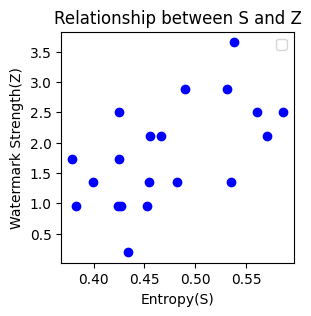

In [20]:
import matplotlib.pyplot as plt

x_column_2 = S_2
y_column_2 = Z_2

plt.figure(figsize=(3,3))

plt.scatter(x_column_2, y_column_2, color='blue') #label =

# Step 4: Add labels and title
plt.xlabel('Entropy(S)')
plt.ylabel('Watermark Strength(Z)')
plt.title('Relationship between S and Z')
plt.legend()

# Display or save the plot
plt.show()

## effect of accelerating landa on z-score

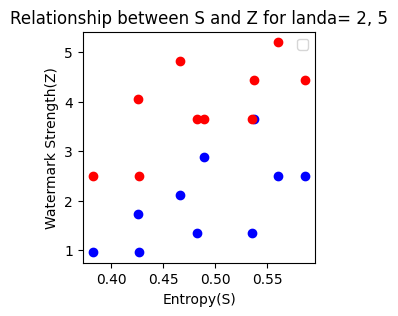

In [21]:
import matplotlib.pyplot as plt

x_column_2 = S_2_5
y_column_2 = Z_2_5
x_column_5 = S_2_5
y_column_5 = Z_5

plt.figure(figsize=(3,3))

plt.scatter(x_column_2, y_column_2, color='blue') #label =
plt.scatter(x_column_5, y_column_5 , color='red')

# Step 4: Add labels and title
plt.xlabel('Entropy(S)')
plt.ylabel('Watermark Strength(Z)')
plt.title('Relationship between S and Z for landa= 2, 5')
plt.legend()

# Display or save the plot
plt.show()

In [ ]:
print(ds['real summary'][2])
print(ds['no watermark (NW)'][2])
print(ds['watermark (W)'][])

A register of patients in England with breast and other cosmetic implants has been set up to allow them to be traced in the event of any safety concerns.
The Breast and Cosmetic Implant Registry will include patients treated by both NHS and private providers. It is expected to record more than 20,000
The new and Cosmetic Implant Registry, include patients treated by both the and private providers. The will expected to record the than to,000


# divide(& conqure)

# Dataset

In [ ]:
! pip install transformers datasets
from datasets import load_dataset
dataset = load_dataset("xsum")

In [ ]:
# Get an overview of the xsum dataset
'''
training_data = dataset["train"]

# Print a sample training example
sample_example = training_data[0]
print("Sample Training Example:")
print("Document:", sample_example["document"])
print("Summary:", sample_example["summary"])
print()

# Calculate the mean number of tokens in 'document' and 'summary'
document_lengths = []
summary_lengths = []

for example in training_data:
    document = example["document"]
    summary = example["summary"]
    document_tokens = tokenizer.encode(document, truncation=True)
    summary_tokens = tokenizer.encode(summary, truncation=True)

    document_lengths.append(len(document_tokens))
    summary_lengths.append(len(summary_tokens))

mean_document_length = sum(document_lengths) / len(document_lengths)
mean_summary_length = sum(summary_lengths) / len(summary_lengths)

print(f"Mean Number of Tokens in 'document': {mean_document_length:.2f}")
print(f"Mean Number of Tokens in 'summary': {mean_summary_length:.2f}")
'''

Mean document Tokens  | Mean summary Tokens
----------------------|------------------
456.69                | 28.15


In [ ]:
for example in dataset["test"]:
    input_text = example["document"]
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate a summary
    summary_ids = model.generate(input_ids, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode and print the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    print("Original Text:", input_text)
    print("Generated Summary:", summary)
    break

Original Text: Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.
Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.
The Welsh Government said more people than ever were getting help to address housing problems.
Changes to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.
Prison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.
However, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.
Andrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the need